In [1]:
# Processing the labels of the raw IMDB data
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels, texts = [], []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
# Tokenizing the text of the raw IMDB data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# cuts off revoews after 100 words
maxlen = 100
# trains on 200 samples
training_samples = 200
# validates on 10000 samples
validation_samples = 10000
# considers onlt the top 10000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [3]:
# Parsing the GloVe word-embeddings file
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [4]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

In [5]:
# Model definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Lodaing pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [7]:
# training and evaluating
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/sample - loss: 2.1717 - acc: 0.4650 - val_loss: 0.8586 - val_acc: 0.5051
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.5381 - acc: 0.7100 - val_loss: 0.7678 - val_acc: 0.5185
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.4715 - acc: 0.8050 - val_loss: 0.8088 - val_acc: 0.5099
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.4240 - acc: 0.8200 - val_loss: 0.7993 - val_acc: 0.5104
Epoch 5/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1849 - acc: 0.9900 - val_loss: 1.3246 - val_acc: 0.4971
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2119 - acc: 0.9150 - val_loss: 1.0093 - val_acc: 0.5044
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1049 - acc: 0.9900 - val_loss: 0.7649 - val_acc: 0.5674
Epoch 8/10
200

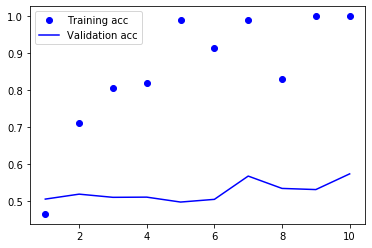

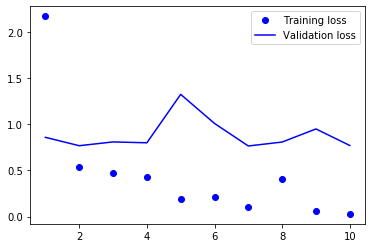

In [8]:
# plotting the result
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [9]:
# tokenizing the data of the test set
train_dir = os.path.join(imdb_dir, 'test')

labels, texts = [], []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [12]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test, verbose=2)

25000/1 - 2s - loss: 0.7455 - acc: 0.5665


[0.7795187710571289, 0.56652]